# Using Kqlmagic to analyze Azure SQL logs and metrics

There are two main tables in Azure Log Analytics (Azure Monitor Logs) workspace that capture Azure SQL events:
1. AzureDiagnostics
2. AzureMetric


## 1. Connect to Log Analytics workspace

Workspace is similar to what a database is to SQL. You connect to Log Analytics workspace to start querying data. 

### 1.1 Load Kqlmagic
Need to load Kqlmagic first before we can start writing queries.


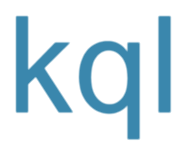

In [2]:
%reload_ext Kqlmagic

### 1.2 Connect to the desired Log Analytics workspace

In [3]:
# Initialize workspace ID to connect to, to analyze Azure SQL log data

workspaceID = ''

In [18]:
if (workspaceID == ''):
    workspaceID = input("Enter Log Analytics Workspace ID (guid)")
    #print(workspaceID)
    print("workspaceID is set") 

In [5]:
%kql loganalytics://code;workspace=workspaceID;alias="myMonLog"  -try-azcli-login-by-profile

## 2. Analyze events by Diagnostic Settings

Let's do a simple query first to analyze the number of events by Operation Name. 

> **Note**: Each row in AzureDiagnostic represents an event for specific Operation or category. Some SQL actions may result in generating multiple events of different types.



In [19]:
%%kql 
AzureDiagnostics
| summarize count() by OperationName

,OperationName,count_
0,AuditEvent,4156
1,DatabaseWaitStatistcsEvent,57
2,QueryStoreRuntimeStatisticsEvent,117
3,ErrorEvent,108
4,DeadlockEvent,2
5,TimeoutEvent,4
6,AutomaticTuningSettingsSnapshotEvent,4


[{'OperationName': 'AuditEvent', 'count_': 4156},
 {'OperationName': 'DatabaseWaitStatistcsEvent', 'count_': 57},
 {'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'count_': 117},
 {'OperationName': 'ErrorEvent', 'count_': 108},
 {'OperationName': 'DeadlockEvent', 'count_': 2},
 {'OperationName': 'TimeoutEvent', 'count_': 4},
 {'OperationName': 'AutomaticTuningSettingsSnapshotEvent', 'count_': 4}]


The above query's equivalent in SQL is:
```
SELECT COUNT(*) AS [count_]
FROM AzureDiagnostics
GROUP BY OperationName
```


Count my Azure SQL DB events by category / diagnostic settings.

In [7]:
%%kql 
AzureDiagnostics
| where LogicalServerName_s == "jukoesmasqldb"
| where TimeGenerated >= ago(5d)
| summarize count() by Category
| render barchart with (title = "Azure SQL DB Diagnostic Category")

[{'Category': 'QueryStoreRuntimeStatistics', 'count_': 45}]

## 3. Performance troubleshooting Query (from Azure Portal)

Potentially a query or deadlock on the system that could lead to poor performance. The following is a query suggested by Azure Portal.

In [22]:
%%kql 
AzureMetrics
| where ResourceProvider == "MICROSOFT.SQL"
| where TimeGenerated >=ago(112d)
| where MetricName in ('deadlock')
| parse _ResourceId with * "/microsoft.sql/servers/" Resource // subtract Resource name for _ResourceId
| summarize Deadlock_max_60Mins = max(Maximum) by Resource, MetricName

,Resource,MetricName,Deadlock_max_60Mins
0,jukoesmasqldb/databases/adventureworks,deadlock,1.0


[{'Resource': 'jukoesmasqldb/databases/adventureworks', 'MetricName': 'deadlock', 'Deadlock_max_60Mins': 1}]

# AzureMetrics

This is a sample query to dig into AzureMetrics

In [9]:
%%kql 
AzureMetrics
| project-away TenantId, ResourceId, SubscriptionId, _ResourceId, ResourceGroup // Don't show sensitive columns :) 
| project TimeGenerated, MetricName, Total, Count, UnitName
| take 10


,TimeGenerated,MetricName,Total,Count,UnitName
0,2021-07-28 01:24:00+00:00,storage_percent,0.000000e+00,2.0,Percent
1,2021-07-28 01:24:00+00:00,log_write_percent,0.000000e+00,4.0,Percent
2,2021-07-28 01:24:00+00:00,storage,1.414660e+09,2.0,Bytes
3,2021-07-28 01:24:00+00:00,physical_data_read_percent,0.000000e+00,4.0,Percent
4,2021-07-28 01:24:00+00:00,sessions_percent,0.000000e+00,4.0,Percent
5,2021-07-28 01:24:00+00:00,dtu_consumption_percent,0.000000e+00,4.0,Percent
6,2021-07-28 01:24:00+00:00,physical_data_read_percent,0.000000e+00,4.0,Percent
7,2021-07-28 01:24:00+00:00,cpu_percent,0.000000e+00,4.0,Percent
8,2021-07-28 01:24:00+00:00,dtu_used,0.000000e+00,1.0,Count
9,2021-07-28 01:24:00+00:00,cpu_percent,0.000000e+00,4.0,Percent


[{'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'storage_percent', 'Total': 0, 'Count': 2, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'log_write_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'storage', 'Total': 1414660096, 'Count': 2, 'UnitName': 'Bytes'},
 {'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'physical_data_read_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'sessions_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'dtu_consumption_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'physical_data_read_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'cpu_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'dtu_used', 'Total': 0, 'Count': 1, 'UnitName': 'Count'},
 {'TimeGenerated': datetime.datetime(2021, 7, 28, 1, 24, tzinfo=tzutc()), 'MetricName': 'cpu_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'}]

# AzureDiagnostics

This is a sample query to dig into AzureDiagnostics. This table tends to have more details than AzureMetrics.

In [10]:
%%kql 
AzureDiagnostics
| project-away TenantId, ResourceId, SubscriptionId, ResourceGroup, _ResourceId // Don't show sensitive columns :) 
| project TimeGenerated, Category, Resource, ResourceType, OperationName
| take 10

,TimeGenerated,Category,Resource,ResourceType,OperationName
0,2021-07-06 09:54:07.783000+00:00,QueryStoreRuntimeStatistics,ADVENTUREWORKS,SERVERS/DATABASES,QueryStoreRuntimeStatisticsEvent
1,2021-07-07 20:53:59.956000+00:00,SQLSecurityAuditEvents,MASTER,SERVERS/DATABASES,AuditEvent
2,2021-07-07 20:53:59.956000+00:00,SQLSecurityAuditEvents,MASTER,SERVERS/DATABASES,AuditEvent
3,2021-07-07 20:53:59.956000+00:00,SQLSecurityAuditEvents,MASTER,SERVERS/DATABASES,AuditEvent
4,2021-07-07 20:53:59.956000+00:00,SQLSecurityAuditEvents,MASTER,SERVERS/DATABASES,AuditEvent
5,2021-07-07 20:53:59.956000+00:00,SQLSecurityAuditEvents,MASTER,SERVERS/DATABASES,AuditEvent
6,2021-07-07 20:53:59.956000+00:00,SQLSecurityAuditEvents,MASTER,SERVERS/DATABASES,AuditEvent
7,2021-07-07 20:53:59.956000+00:00,SQLSecurityAuditEvents,MASTER,SERVERS/DATABASES,AuditEvent
8,2021-07-07 20:53:59.956000+00:00,SQLSecurityAuditEvents,MASTER,SERVERS/DATABASES,AuditEvent
9,2021-07-07 20:53:59.956000+00:00,SQLSecurityAuditEvents,MASTER,SERVERS/DATABASES,AuditEvent


[{'TimeGenerated': datetime.datetime(2021, 7, 6, 9, 54, 7, 783000, tzinfo=tzutc()), 'Category': 'QueryStoreRuntimeStatistics', 'Resource': 'ADVENTUREWORKS', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'QueryStoreRuntimeStatisticsEvent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 7, 20, 53, 59, 956000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 7, 20, 53, 59, 956000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 7, 20, 53, 59, 956000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 7, 20, 53, 59, 956000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 7, 20, 53, 59, 956000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 7, 20, 53, 59, 956000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 7, 20, 53, 59, 956000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 7, 20, 53, 59, 956000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent'},
 {'TimeGenerated': datetime.datetime(2021, 7, 7, 20, 53, 59, 956000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent'}]

## Analyze (non-audit) Events

In [11]:
%%kql 
AzureDiagnostics
| summarize event_count=count() by bin(TimeGenerated, 2d), OperationName
| where OperationName <> "AuditEvent"
| render timechart 

[{'TimeGenerated': datetime.datetime(2021, 7, 6, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 7, 20, 0, 0, tzinfo=tzutc()), 'OperationName': 'DatabaseWaitStatistcsEvent', 'event_count': 32},
 {'TimeGenerated': datetime.datetime(2021, 7, 20, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 38},
 {'TimeGenerated': datetime.datetime(2021, 7, 20, 0, 0, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 57},
 {'TimeGenerated': datetime.datetime(2021, 7, 18, 0, 0, tzinfo=tzutc()), 'OperationName': 'DatabaseWaitStatistcsEvent', 'event_count': 4},
 {'TimeGenerated': datetime.datetime(2021, 7, 18, 0, 0, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 21},
 {'TimeGenerated': datetime.datetime(2021, 7, 18, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 11},
 {'TimeGenerated': datetime.datetime(2021, 7, 18, 0, 0, tzinfo=tzutc()), 'OperationName': 'DeadlockEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 7, 20, 0, 0, tzinfo=tzutc()), 'OperationName': 'TimeoutEvent', 'event_count': 4},
 {'TimeGenerated': datetime.datetime(2021, 7, 20, 0, 0, tzinfo=tzutc()), 'OperationName': 'AutomaticTuningSettingsSnapshotEvent', 'event_count': 4},
 {'TimeGenerated': datetime.datetime(2021, 7, 22, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 39},
 {'TimeGenerated': datetime.datetime(2021, 7, 26, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 7},
 {'TimeGenerated': datetime.datetime(2021, 6, 30, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 2},
 {'TimeGenerated': datetime.datetime(2021, 6, 30, 0, 0, tzinfo=tzutc()), 'OperationName': 'DatabaseWaitStatistcsEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 6, 30, 0, 0, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 2},
 {'TimeGenerated': datetime.datetime(2021, 7, 2, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 2},
 {'TimeGenerated': datetime.datetime(2021, 7, 16, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 4},
 {'TimeGenerated': datetime.datetime(2021, 7, 14, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 9},
 {'TimeGenerated': datetime.datetime(2021, 7, 14, 0, 0, tzinfo=tzutc()), 'OperationName': 'DatabaseWaitStatistcsEvent', 'event_count': 4},
 {'TimeGenerated': datetime.datetime(2021, 7, 8, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 2},
 {'TimeGenerated': datetime.datetime(2021, 7, 16, 0, 0, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 28},
 {'TimeGenerated': datetime.datetime(2021, 7, 16, 0, 0, tzinfo=tzutc()), 'OperationName': 'DeadlockEvent', 'event_count': 1}]

## Deadlock Analysis

In [12]:
%%kql 
AzureDiagnostics
| where OperationName == "DeadlockEvent"
| project TimeGenerated, Category, Resource, OperationName, Type, deadlock_xml_s
| sort by TimeGenerated desc
| take 50

,TimeGenerated,Category,Resource,OperationName,Type,deadlock_xml_s
0,2021-07-19 13:55:22.268000+00:00,Deadlocks,ADVENTUREWORKS,DeadlockEvent,AzureDiagnostics,<deadlock> <victim-list> <victimProcess i...
1,2021-07-17 23:13:34.608000+00:00,Deadlocks,ADVENTUREWORKS,DeadlockEvent,AzureDiagnostics,<deadlock> <victim-list> <victimProcess i...


[{'TimeGenerated': datetime.datetime(2021, 7, 19, 13, 55, 22, 268000, tzinfo=tzutc()), 'Category': 'Deadlocks', 'Resource': 'ADVENTUREWORKS', 'OperationName': 'DeadlockEvent', 'Type': 'AzureDiagnostics', 'deadlock_xml_s': "<deadlock>   <victim-list>    <victimProcess id='process1e9a7b324e8'/>   </victim-list>   <process-list>    <process id='process1e9a7b324e8' taskpriority='0' logused='388' waitresource='KEY: 5:72057594047037440 (5495ec521809)' waittime='15032' ownerId='28766101' transactionname='user_transaction' lasttranstarted='2021-07-19T13:55:07.217' XDES='0x1e9b5d20428' lockMode='U' schedulerid='2' kpid='64416' status='suspended' spid='92' sbid='0' ecid='0' priority='0' trancount='2' lastbatchstarted='2021-07-19T13:55:07.213' lastbatchcompleted='2021-07-19T13:55:07.167' lastattention='1900-01-01T00:00:00.167' clientapp='azdata-Query' hostname='filtered' hostpid='25504' loginname='filtered' isolationlevel='read committed (2)' xactid='28766101' currentdb='5' currentdbname='AdventureWorks' lockTimeout='4294967295' clientoption1='671156320' clientoption2='128056'>     <executionStack>      <frame procname='unknown' queryhash='0xfb56c41f149be1bf' queryplanhash='0x61108d8e53ae0281' line='7' stmtstart='236' stmtend='398' sqlhandle='0x0200000076fe5d1c0c6a574e5832f3b8ff93e633e3a1d6ae0000000000000000000000000000000000000000'>  unknown    </frame>      <frame procname='unknown' queryhash='0xfb56c41f149be1bf' queryplanhash='0x61108d8e53ae0281' line='7' stmtstart='236' stmtend='398' sqlhandle='0x0200000005a1aa314a4b357187cf390d3dc4890a0bd7a7c10000000000000000000000000000000000000000'>  unknown    </frame>     </executionStack>     <inputbuf>  filtered   </inputbuf>    </process>    <process id='process1e9b60d8ca8' taskpriority='0' logused='572' waitresource='KEY: 5:72057594046971904 (8194443284a0)' waittime='4252' ownerId='28765868' transactionname='user_transaction' lasttranstarted='2021-07-19T13:55:03' XDES='0x1e9c6b24428' lockMode='U' schedulerid='2' kpid='35836' status='suspended' spid='86' sbid='0' ecid='0' priority='0' trancount='2' lastbatchstarted='2021-07-19T13:55:03' lastbatchcompleted='2021-07-19T13:55:00.540' lastattention='1900-01-01T00:00:00.540' clientapp='azdata-Query' hostname='filtered' hostpid='25504' loginname='filtered' isolationlevel='read committed (2)' xactid='28765868' currentdb='5' currentdbname='AdventureWorks' lockTimeout='4294967295' clientoption1='671156320' clientoption2='128056'>     <executionStack>      <frame procname='unknown' queryhash='0xa57159d12cb813fb' queryplanhash='0x10cbf3310dab2eb5' line='9' stmtstart='58' stmtend='186' sqlhandle='0x020000009897910214549261257b982dc5f67c7e4f562ee10000000000000000000000000000000000000000'>  unknown    </frame>      <frame procname='unknown' queryhash='0xa57159d12cb813fb' queryplanhash='0x10cbf3310dab2eb5' line='9' stmtstart='382' stmtend='520' sqlhandle='0x020000003cbaf1075f6082bedf3e15172fe9ecb6c23b78160000000000000000000000000000000000000000'>  unknown    </frame>     </executionStack>     <inputbuf>  filtered   </inputbuf>    </process>   </process-list>   <resource-list>    <keylock hobtid='72057594047037440' dbid='5' objectname='filtered' indexname='filtered' id='lock1e9cd44b080' mode='X' associatedObjectId='72057594047037440'>     <owner-list>      <owner id='process1e9b60d8ca8' mode='X'/>     </owner-list>     <waiter-list>      <waiter id='process1e9a7b324e8' mode='U' requestType='wait'/>     </waiter-list>    </keylock>    <keylock hobtid='72057594046971904' dbid='5' objectname='filtered' indexname='filtered' id='lock1e9befe6880' mode='X' associatedObjectId='72057594046971904'>     <owner-list>      <owner id='process1e9a7b324e8' mode='X'/>     </owner-list>     <waiter-list>      <waiter id='process1e9b60d8ca8' mode='U' requestType='wait'/>     </waiter-list>    </keylock>   </resource-list>  </deadlock>  "},
 {'TimeGenerated': datetime.datetime(2021, 7, 17, 23, 13, 34, 608000, tzinfo=tzutc()), 'Category': 'Deadlocks', 'Resource': 'ADVENTUREWORKS

Find the deadlock query plan

In [13]:
%%kql 
AzureDiagnostics
| where OperationName == "DeadlockEvent"
| extend d = parse_xml(deadlock_xml_s)
| project TimeGenerated, QuerhPlanHash = d.deadlock.["process-list"].process[0].executionStack.frame[0]["@queryplanhash"], QueryHash = d.deadlock.["process-list"].process[0].executionStack.frame[0]["@queryhash"]
//| sort by TimeGenerated desc
| take 50

,TimeGenerated,QuerhPlanHash,QueryHash
0,2021-07-19 13:55:22.268000+00:00,0x61108d8e53ae0281,0xfb56c41f149be1bf
1,2021-07-17 23:13:34.608000+00:00,0x61108d8e53ae0281,0xfb56c41f149be1bf


[{'TimeGenerated': datetime.datetime(2021, 7, 19, 13, 55, 22, 268000, tzinfo=tzutc()), 'QuerhPlanHash': '0x61108d8e53ae0281', 'QueryHash': '0xfb56c41f149be1bf'},
 {'TimeGenerated': datetime.datetime(2021, 7, 17, 23, 13, 34, 608000, tzinfo=tzutc()), 'QuerhPlanHash': '0x61108d8e53ae0281', 'QueryHash': '0xfb56c41f149be1bf'}]

## Query Store Runtime Statistics Events

In [14]:
%%kql 
AzureDiagnostics
| where OperationName == "QueryStoreRuntimeStatisticsEvent"
| project TimeGenerated, query_hash_s, statement_sql_handle_s, query_plan_hash_s
| take 10

,TimeGenerated,query_hash_s,statement_sql_handle_s,query_plan_hash_s
0,2021-07-23 03:39:13.619000+00:00,0xD0B172EC3AC90AB2,0x0900F0816A25DA2ADDAACB957F82B882EC1600000000...,0x2B9A3A3B55B4B6CB
1,2021-07-23 08:59:06.678000+00:00,0x6B4B44D6B25ADD20,0x090077EE742616D2343B59A6A7DD4F1BCDD100000000...,0x083AA300570224D3
2,2021-07-23 08:59:06.678000+00:00,0xA2130AA67E367881,0x090051874822F6B5B22CD377965CB73C87C600000000...,0x208410BECFEC3EF3
3,2021-07-23 08:59:06.678000+00:00,0x828133C52F90EB6D,0x090013440DCE3264CE77F7337FB744CEDA5100000000...,0x168E4ED332FE0208
4,2021-07-23 08:59:06.678000+00:00,0xD0B172EC3AC90AB2,0x0900F0816A25DA2ADDAACB957F82B882EC1600000000...,0xA9B21A725D50B14E
5,2021-07-23 08:59:06.678000+00:00,0x09FAA9C7FB0B074F,0x0900FCDAB7B20133B0ECE39573A89245BA3200000000...,0x16B3C73492EFCB4D
6,2021-07-23 08:59:06.678000+00:00,0x58A8C7A925C12FA6,0x09003088040C0034FCFF27D5BDCCEA98D46F00000000...,0x7A983A35BE23B580
7,2021-07-23 08:59:06.678000+00:00,0x12EC62308821AB40,0x09008297434DEFF2513E39B4B0DDE8F916EB00000000...,0xB189351EDDF42C85
8,2021-07-23 05:44:03.888000+00:00,0xD0B172EC3AC90AB2,0x0900F0816A25DA2ADDAACB957F82B882EC1600000000...,0xA9B21A725D50B14E
9,2021-07-23 05:44:03.888000+00:00,0x09FAA9C7FB0B074F,0x0900FCDAB7B20133B0ECE39573A89245BA3200000000...,0x16B3C73492EFCB4D


[{'TimeGenerated': datetime.datetime(2021, 7, 23, 3, 39, 13, 619000, tzinfo=tzutc()), 'query_hash_s': '0xD0B172EC3AC90AB2', 'statement_sql_handle_s': '0x0900F0816A25DA2ADDAACB957F82B882EC160000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x2B9A3A3B55B4B6CB'},
 {'TimeGenerated': datetime.datetime(2021, 7, 23, 8, 59, 6, 678000, tzinfo=tzutc()), 'query_hash_s': '0x6B4B44D6B25ADD20', 'statement_sql_handle_s': '0x090077EE742616D2343B59A6A7DD4F1BCDD10000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x083AA300570224D3'},
 {'TimeGenerated': datetime.datetime(2021, 7, 23, 8, 59, 6, 678000, tzinfo=tzutc()), 'query_hash_s': '0xA2130AA67E367881', 'statement_sql_handle_s': '0x090051874822F6B5B22CD377965CB73C87C60000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x208410BECFEC3EF3'},
 {'TimeGenerated': datetime.datetime(2021, 7, 23, 8, 59, 6, 678000, tzinfo=tzutc()), 'query_hash_s': '0x828133C52F90EB6D', 'statement_sql_handle_s': '0x090013440DCE3264CE77F7337FB744CEDA510000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x168E4ED332FE0208'},
 {'TimeGenerated': datetime.datetime(2021, 7, 23, 8, 59, 6, 678000, tzinfo=tzutc()), 'query_hash_s': '0xD0B172EC3AC90AB2', 'statement_sql_handle_s': '0x0900F0816A25DA2ADDAACB957F82B882EC160000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0xA9B21A725D50B14E'},
 {'TimeGenerated': datetime.datetime(2021, 7, 23, 8, 59, 6, 678000, tzinfo=tzutc()), 'query_hash_s': '0x09FAA9C7FB0B074F', 'statement_sql_handle_s': '0x0900FCDAB7B20133B0ECE39573A89245BA320000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x16B3C73492EFCB4D'},
 {'TimeGenerated': datetime.datetime(2021, 7, 23, 8, 59, 6, 678000, tzinfo=tzutc()), 'query_hash_s': '0x58A8C7A925C12FA6', 'statement_sql_handle_s': '0x09003088040C0034FCFF27D5BDCCEA98D46F0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x7A983A35BE23B580'},
 {'TimeGenerated': datetime.datetime(2021, 7, 23, 8, 59, 6, 678000, tzinfo=tzutc()), 'query_hash_s': '0x12EC62308821AB40', 'statement_sql_handle_s': '0x09008297434DEFF2513E39B4B0DDE8F916EB0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0xB189351EDDF42C85'},
 {'TimeGenerated': datetime.datetime(2021, 7, 23, 5, 44, 3, 888000, tzinfo=tzutc()), 'query_hash_s': '0xD0B172EC3AC90AB2', 'statement_sql_handle_s': '0x0900F0816A25DA2ADDAACB957F82B882EC160000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0xA9B21A725D50B14E'},
 {'TimeGenerated': datetime.datetime(2021, 7, 23, 5, 44, 3, 888000, tzinfo=tzutc()), 'query_hash_s': '0x09FAA9C7FB0B074F', 'statement_sql_handle_s': '0x0900FCDAB7B20133B0ECE39573A89245BA320000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x16B3C73492EFCB4D'}]

## Analyze Errors

In [15]:
%%kql 
AzureDiagnostics
| where OperationName == "ErrorEvent"
| extend ErrorNumber =  tostring(error_number_d) 
| summarize event_count=count() by EventTime = bin(TimeGenerated, 2d), ErrorNumber
| render timechart 

[{'EventTime': datetime.datetime(2021, 6, 30, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 2},
 {'EventTime': datetime.datetime(2021, 7, 20, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 47},
 {'EventTime': datetime.datetime(2021, 7, 18, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 20},
 {'EventTime': datetime.datetime(2021, 7, 18, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '3902.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 7, 20, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '2714.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 7, 20, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '1222.0', 'event_count': 8},
 {'EventTime': datetime.datetime(2021, 7, 20, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '3902.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 7, 16, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 27},
 {'EventTime': datetime.datetime(2021, 7, 16, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '3902.0', 'event_count': 1}]

## Find Deleted table

In [16]:
%%kql 
AzureDiagnostics
| where action_name_s in ('BATCH COMPLETED')
| project TimeGenerated, Category, action_name_s, statement_s
| where statement_s contains "DROP TABLE"
| sort by TimeGenerated desc 
| take 10



,TimeGenerated,Category,action_name_s,statement_s
0,2021-07-21 02:26:55.404000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....
1,2021-07-21 02:26:55.404000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....
2,2021-07-21 02:26:15.388000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....
3,2021-07-21 02:26:15.388000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....
4,2021-07-21 02:24:17.308000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....
5,2021-07-21 02:24:17.308000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....
6,2021-07-21 02:22:25.275000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....
7,2021-07-21 02:22:25.275000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....
8,2021-07-19 13:55:35.845000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....
9,2021-07-19 13:55:35.845000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo]....


[{'TimeGenerated': datetime.datetime(2021, 7, 21, 2, 26, 55, 404000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'},
 {'TimeGenerated': datetime.datetime(2021, 7, 21, 2, 26, 55, 404000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'},
 {'TimeGenerated': datetime.datetime(2021, 7, 21, 2, 26, 15, 388000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'},
 {'TimeGenerated': datetime.datetime(2021, 7, 21, 2, 26, 15, 388000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'},
 {'TimeGenerated': datetime.datetime(2021, 7, 21, 2, 24, 17, 308000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'},
 {'TimeGenerated': datetime.datetime(2021, 7, 21, 2, 24, 17, 308000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'},
 {'TimeGenerated': datetime.datetime(2021, 7, 21, 2, 22, 25, 275000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'},
 {'TimeGenerated': datetime.datetime(2021, 7, 21, 2, 22, 25, 275000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'},
 {'TimeGenerated': datetime.datetime(2021, 7, 19, 13, 55, 35, 845000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'},
 {'TimeGenerated': datetime.datetime(2021, 7, 19, 13, 55, 35, 845000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE [dbo].[Person]\r\nDROP TABLE [dbo].[PersonPhone]'}]